In [ ]:
WEIGHTS_ABSOLUTE_PATH = '/content/gdrive/MyDrive/snake.reinforce.json'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
md5 = !md5sum 'snake_game.py'
assert 'fe6f1b08c885095e7425b25c5a7ad9e5' == md5[0].split()[0]

In [ ]:
from snake_game import SnakeGame
from datetime import datetime, timedelta
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import copy
import json
print('tensorflow', tf.__version__)
!python -V

tensorflow 2.8.2
Python 3.7.13


In [ ]:
env = SnakeGame()

In [ ]:
def extract_features(game=env):
  obsticle = lambda k: copy.deepcopy(game).step(k).done
  snake, food = game.get_state()
  head,  food = [h + w * game.board_height for h, w in (snake.head, food)]
  obs = sum(v << i for i, v in enumerate(obsticle(k) for k in game.ACTION))
  max = game.board_height * game.board_width - 1
  return obs / 0b1111, head / max, food / max

In [ ]:
def build_model():
  x_in = x = keras.Input(shape=(3,))
  x = keras.layers.Dense(32, activation='relu')(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  x = keras.layers.Dense(len(env.ACTION))(x)

  model = keras.Model(x_in, x)

  model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer='Nadam')
  model.summary()
  return model

In [ ]:
model = build_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 1,316
Trainable params: 1,316
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def play_game():
  env.reset()
  game_data = []
  done = False
  while not done:
    features = extract_features()
    action = model(tf.expand_dims(features, 0), training=False)
    action = tf.squeeze(tf.random.categorical(action, 1))
    _, reward, done, info = env.step(action)
    game_data.append((features, action, -1e-2 if reward < 0 else reward))
  return game_data, info.score

In [ ]:
disc = lambda r: tf.scan(lambda a, x: x + .9 * a, r, reverse=True)
disc(tf.stack([0, 0, 1, 0, 1, 0, -1e-2])).numpy()

array([ 1.4607855 ,  1.623095  ,  1.803439  ,  0.89271003,  0.9919    ,
       -0.009     , -0.01      ], dtype=float32)

In [ ]:
def reinforce(time_limit=timedelta(hours=11, minutes=50)):
  history = []
  best_score = -float('inf')
  stop_time = datetime.now() + time_limit
  while datetime.now() < stop_time:
    data, score = play_game()
    if best_score < score:
      best_score = score
      model.save_weights('best_weights.h5')
    X, Y, R = [tf.stack(i) for i in zip(*data)]
    history.append((
      model.train_on_batch(X, Y, sample_weight=disc(R)),
      float(tf.math.count_nonzero(R > 0) - 1), len(Y), score))
    if len(history) % 10 == 0:
      log = zip(*history[-100:])
      print('\r%5d' % len(history),
            '| Loss: %7.4f'   % tf.reduce_mean(next(log)),
            '| Reward: %5.2f' % tf.reduce_mean(next(log)),
            '| Age: %4d'      % tf.reduce_mean(next(log)),
            '| Score: %4d'    % tf.reduce_mean(next(log)),
            '| Best: %4d'     % best_score,
            '| %d %%' % (100 * (1 - (stop_time - datetime.now()) / time_limit)),
            end = '')
  return history

In [ ]:
history = zip(*reinforce())
plt.rc('figure', figsize=(13, 4))

22170 | Loss:  0.0016 | Reward: 21.14 | Age:  762 | Score: 1474 | Best: 4789 | 99 %

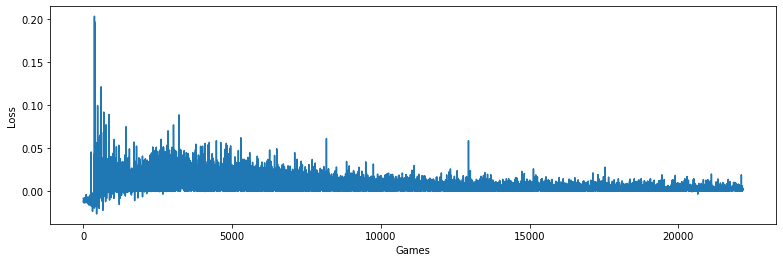

In [ ]:
plt.plot(next(history))
plt.ylabel('Loss')
plt.xlabel('Games') and None

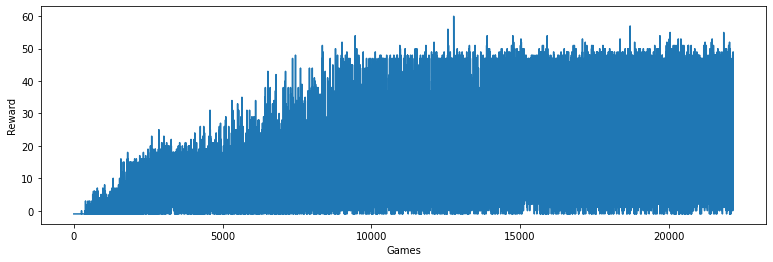

In [ ]:
plt.plot(next(history))
plt.ylabel('Reward')
plt.xlabel('Games') and None

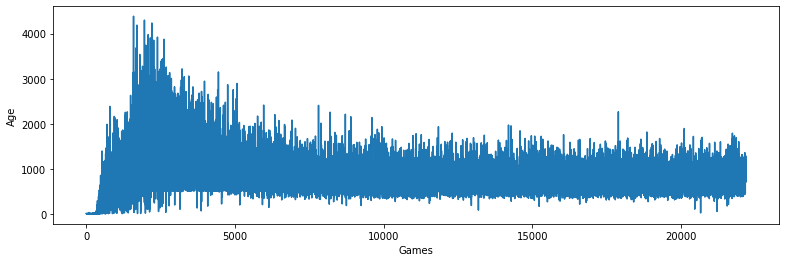

In [ ]:
plt.plot(next(history))
plt.ylabel('Age')
plt.xlabel('Games') and None

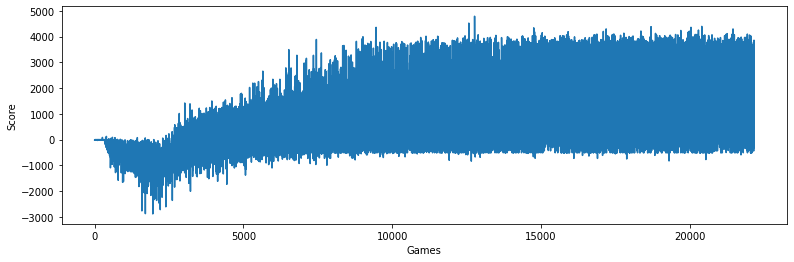

In [ ]:
plt.plot(next(history))
plt.ylabel('Score')
plt.xlabel('Games') and None

In [ ]:
model.load_weights('best_weights.h5')

In [ ]:
model.predict(tf.stack([(0,)*model.input_shape[-1],
                        (1,)*model.input_shape[-1]]))

array([[  5.8412104,  -4.8576665,  -5.276733 ,  -1.5355242],
       [  6.1069336, -12.892834 , -12.935051 ,   5.11665  ]],
      dtype=float32)

In [ ]:
with open(WEIGHTS_ABSOLUTE_PATH, 'w') as f:
  json.dump([w.tolist() for w in model.get_weights()], f)
!md5sum "$WEIGHTS_ABSOLUTE_PATH"

e415c8070ee60176e739dffa95de5b4b  /content/gdrive/MyDrive/snake.reinforce.json
